In [1]:
import sys, os, time
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = train.get_dataset('cr-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], train=True)
# len(dataset)

In [ ]:
dataset = train.get_dataset('3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=True)
len(dataset)

In [ ]:
dataset = train.get_dataset('rgbball-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=False)
len(dataset)

In [ ]:
dataset = train.get_dataset('rgbball2-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=False)
len(dataset)

In [ ]:
dataset.factor_order

In [ ]:
# i = -1

223277
tensor([ 0.2000,  0.0000,  0.3000,  0.8929,  2.0000, -4.2857])


<IPython.core.display.Javascript object>


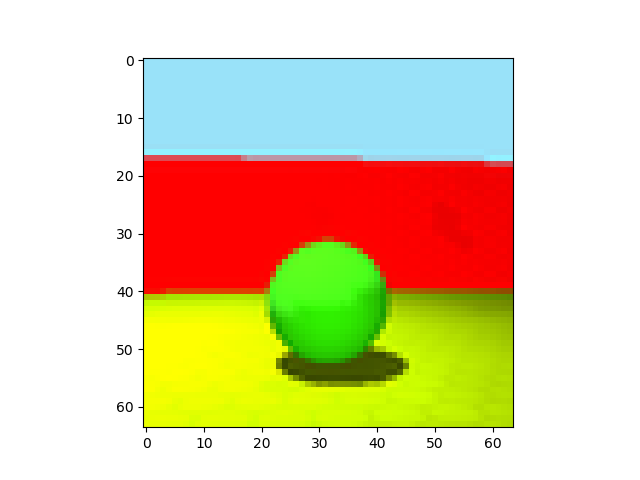

In [28]:
# i += 1
i = np.random.randint(len(dataset))
print(i)
sample = dataset[i]
if len(sample) > 1:
    x,y = dataset[i]
    print(y)
else:
    x, = dataset[i]
plt.imshow(x.permute(1,2,0).numpy())

tensor([ 0.2000,  0.7000,  0.3000,  1.1071,  3.0000, 12.8571])

In [8]:
self = dataset

In [9]:
sel = torch.logical_not(self.labels[:, 2].isclose(torch.tensor(0.))
       + self.labels[:, 2].isclose(torch.tensor(0.3))
       + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

rep = (self.labels[:, 2].isclose(torch.tensor(0.))
        + self.labels[:, 2].isclose(torch.tensor(0.3))
        + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

replacements = self.images[rep]
replacements.shape

torch.Size([28809, 3, 64, 64])

In [31]:
sidx = torch.arange(self.images.shape[0])[sel]
ridx = torch.arange(self.images.shape[0])[rep]
sidx.shape, ridx.shape

(torch.Size([67201]), torch.Size([28809]))

In [33]:
lost = sel.sum().item()
swaps = rep.sum().item()
lost, swaps

(67201, 28809)

In [34]:
copies, extra = lost // swaps, lost % swaps

In [35]:
extra_idx = torch.randperm(swaps)[:extra]
extra_idx.shape

torch.Size([9583])

In [38]:
reps = torch.cat([ridx]*copies + [extra_idx])
reps.shape

torch.Size([67201])

In [39]:
self.images[sidx] = self.images[reps]

tensor(67201)

In [13]:
67201 / replacements.shape[0]

2.332639105834982

In [15]:
67201 % replacements.shape[0]

9583

In [ ]:
9583

In [ ]:
torch.randperm()

In [3]:
dataset = train.get_dataset('z-celeba', dataroot=os.environ['FOUNDATION_DATA_DIR'], label_type='attr')

NameError: name 'train' is not defined

In [ ]:
i = np.random.randint(len(dataset))

In [ ]:
x, y = dataset[i]
x.shape, y.shape

In [ ]:
plt.imshow(x.permute(1,2,0).numpy())